<a href="https://www.kaggle.com/code/abd0kamel/mutemotion-asl-citizen-translation-model?scriptVersionId=161375595" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Introduction**

<h3> This notebook aims to use MediaPipe landmarks detection as the starting point
    
<h3> for building an American Sign Language Translation Model using <b>ASL Citizen</b> Dataset
            
**<h3> Sections:**
* [Importing Libraries](#Importing_Libraries)
* [Data Preparation](#Data_Preparation)
* [MediaPipe Implementation](#MediaPipe_Implementation)
* [Visualizing Landmarks](#Visualizing_Landmarks)
* [Data Encoding](#Data_Encoding)
* [Label Filtering](#Label_Filtering)
* [Data Loading](#Data_Loading) --> (Training Start Here)
* [Data Augmentation](#Data_Augmentation)
* [Data Preprocessing](#Data_Preprocessing)
* [Label Encoding](#Label_Encoding)
* [Model Training](#Model_Training)
* [Model Visualization](#Model_Visualization)

---

<div id="Importing_Libraries">
    
# **Importing Libraries** 

In [1]:
!pip install -q mediapipe==0.10.7

In [2]:
import os
import gc
import cv2
import json
import time
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink

2024-02-02 04:13:54.506064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 04:13:54.506184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 04:13:54.798806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


---

<div id="Data_Preparation">
    
# **Data Preparation**
**<h2>(Done Once)**

In [ ]:
train_path = '/kaggle/input/asl-citizen/ASL_Citizen/splits/train.csv'
val_path = '/kaggle/input/asl-citizen/ASL_Citizen/splits/val.csv'
test_path = '/kaggle/input/asl-citizen/ASL_Citizen/splits/test.csv'

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [ ]:
train_data['split'] = 'train'
val_data['split'] = 'val'
test_data['split'] = 'test'

train_data = train_data[['Video file', 'Gloss', 'split']]
val_data = val_data[['Video file', 'Gloss', 'split']]
test_data = test_data[['Video file', 'Gloss', 'split']]

data = pd.concat([train_data, val_data, test_data], ignore_index=True)
data = data.sample(frac=1, random_state=42, ignore_index=True)
data = data.rename(columns={'Gloss':'label', 'Video file': 'video'})
data.head()

In [ ]:
def extract_label(file_name):
    label_parts = file_name.split("-")[1].split(".")[0].replace("_", " ").split(" ")
    label_parts = [part for part in label_parts if part != '']
    if label_parts[0].startswith('seed'):
        label_parts[0] = label_parts[0][4:]
    if label_parts[-1].isdigit():
        label_parts = label_parts[:-1]
    label_parts = [part.lower() for part in label_parts]
    return ' '.join(label_parts)

In [ ]:
data.insert(data.columns.get_loc('label') + 1, 'clean label', data['video'].apply(extract_label))
data.head()

In [ ]:
data[data['clean label'] == '']

In [ ]:
data.iloc[59741, data.columns.get_loc('clean label')] = 'sour'
data[data['clean label'] == '']

In [ ]:
data.to_csv("data.csv", index=False)

---

<div id="MediaPipe_Implementation">

# **MediaPipe Implementation**
**<h2>(Not important when training)**

In [ ]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

In [ ]:
hands = mp.solutions.hands.Hands()
pose = mp.solutions.pose.Pose()
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)

def get_frame_landmarks(frame):
    
    all_landmarks = np.zeros((HAND_NUM * 2 + POSE_NUM + FACE_NUM, 3))
    
    def get_hands(frame):
        results_hands = hands.process(frame)
        if results_hands.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                if results_hands.multi_handedness[i].classification[0].index == 0: 
                    all_landmarks[:HAND_NUM, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # right
                else:
                    all_landmarks[HAND_NUM:HAND_NUM * 2, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # left

    def get_pose(frame):
        results_pose = pose.process(frame)
        if results_pose.pose_landmarks:
            all_landmarks[HAND_NUM * 2:HAND_NUM * 2 + POSE_NUM, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
        
    def get_face(frame):
        results_face = face_mesh.process(frame)
        if results_face.multi_face_landmarks:
            all_landmarks[HAND_NUM * 2 + POSE_NUM:, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]
        
    with ThreadPoolExecutor(max_workers=3) as executor:
        executor.submit(get_hands, frame)
        executor.submit(get_pose, frame)
        executor.submit(get_face, frame)

    return all_landmarks

In [ ]:
def get_video_landmarks(video_path):
    cap = cv2.VideoCapture(video_path)
    all_frame_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        frame.flags.writeable = False
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_landmarks = get_frame_landmarks(frame)
        all_frame_landmarks.append(frame_landmarks)

    with ThreadPoolExecutor(max_workers=4) as executor:
        executor.submit(cap.release)
        executor.submit(hands.reset)
        executor.submit(pose.reset)
        executor.submit(face_mesh.reset)
        
    return np.array(all_frame_landmarks)

In [ ]:
def draw_landmarks(input_path, output_path, video_landmarks):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_landmarks = video_landmarks[frame_index]
        landmarks = [(int(x * width), int(y * height)) for x, y, _ in frame_landmarks]
        for x, y in landmarks:
            cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
        out.write(frame)
        frame_index += 1

    cap.release()
    out.release()

---

<div id="Visualizing_Landmarks">

# **Visualizing Landmarks**
**<h2>(Not important when training)**

In [ ]:
import requests
from PIL import Image
from io import BytesIO

image_url = 'https://images.unsplash.com/photo-1515294898968-a408405d7674'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [ ]:
height, width, _ = img.shape

frame_landmarks = get_frame_landmarks(img[:,:,::-1])
for landmark in frame_landmarks:
    x = int(landmark[0] * width)
    y = int(landmark[1] * height)
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [ ]:
test = data.iloc[75]
video_dir = '/kaggle/input/asl-citizen/ASL_Citizen/videos'
input_path = os.path.join(video_dir, test['video'])
video_landmarks = get_video_landmarks(input_path)

output_path = '/kaggle/working/landmarks_test.mp4'
draw_landmarks(input_path, output_path, video_landmarks)

---

<div id="Data_Encoding">
    
# **Data Encoding**
**<h2>(Done Once)**

In [ ]:
txt_path = '/kaggle/working/completed.txt'
video_dir = '/kaggle/input/asl-citizen/ASL_Citizen/videos'
npy_dir = '/kaggle/working/landmarks'
os.makedirs(npy_dir, exist_ok=True)

In [ ]:
labels = []
with open('/kaggle/working/Filtered Labels/filtered_labels_221.txt', 'r') as file:
    labels = file.read().splitlines()
    
len(labels)

In [ ]:
data = pd.read_csv('/kaggle/input/asl-citizen-encoded/Data/data.csv')
data = data[data['clean label'].isin(labels)].reset_index(drop=True)
data.head()

In [ ]:
len(data)

In [ ]:
try:
    completed_files = set()
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as file:
            completed_files = {line.strip() for line in file}
            
    for i in tqdm(range(len(data)), ncols=100):
        video_name = data.iloc[i]['video'].split('.')[0]
        if video_name in completed_files: continue
        npy_path = os.path.join(npy_dir, f'{video_name}.npy')
        video_path = os.path.join(video_dir, f'{video_name}.mp4')

        try:
            video_landmarks = get_video_landmarks(video_path)
            np.save(npy_path, video_landmarks)
            
            with open(txt_path, 'a') as file:
                file.write(f"{video_name}\n")
            completed_files.add(video_name)
            
        except Exception as e:
            print(f"\nError encoding {i}: {video_path}\n{e}")
            continue   
        clear_output(wait=True)

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

In [ ]:
landmarks_dict = {}

for filename in os.listdir(npy_dir):
    if filename.endswith('.npy'):
        key = os.path.splitext(filename)[0]
        landmarks = np.load(os.path.join(npy_dir, filename), allow_pickle=True)
        landmarks_dict[key] = landmarks

np.savez_compressed('/kaggle/working/landmarks.npz', **landmarks_dict)

FileLink(r'landmarks.npz')

In [ ]:
# shutil.rmtree(npy_dir)
# os.remove('/kaggle/working/completed.txt')
# os.remove('/kaggle/working/landmarks_test.mp4')

---

<div id="Label_Filtering">

# **Label Filtering**
**<h2>(Done Once)**

In [ ]:
import fasttext
import fasttext.util

fasttext.util.download_model('en', if_exists='ignore')

In [ ]:
import fasttext

ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
data = pd.read_csv('/kaggle/input/asl-citizen-encoded/Data/data.csv')
labels = data['clean label'].unique().tolist()
len(data), len(labels)

In [ ]:
labels_dir = '/kaggle/working/Vector Encoded Labels'
os.makedirs(labels_dir, exist_ok=True)

for i in tqdm(range(len(labels)), ncols=100):
    label_vector = ft.get_sentence_vector(labels[i])
    label_path = os.path.join(labels_dir, f'{labels[i]}.npy')
    np.save(label_path, label_vector)

In [ ]:
labels_dir = '/kaggle/input/asl-citizen-encoded/Vector Encoded Labels'
encoded_labels = {}

for filename in os.listdir(labels_dir):
    if filename.endswith('.npy'):
        label = os.path.splitext(filename)[0]
        encoded_label = np.load(os.path.join(labels_dir, filename), allow_pickle=True)
        encoded_labels[label] = encoded_label
        
len(encoded_labels)

In [ ]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
word = 'taxi'
word_vector = ft.get_sentence_vector(word)

similarity_scores = []
for label, label_vector in encoded_labels.items():
    similarity_scores.append(cosine_similarity(word_vector, label_vector))

In [ ]:
bins = np.linspace(0, 1, 21)

plt.hist(similarity_scores, bins=bins, edgecolor='black')
plt.title(f'Cosine Similarity Distribution to "{word}"')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y')
plt.show()

In [ ]:
threshold = 0.4
similar_words_set = set()

for label, label_vector in encoded_labels.items():
    similarity_score = cosine_similarity(word_vector, label_vector)
    if similarity_score > threshold:
        similar_words_set.add(label)
        
print(similar_words_set)

In [ ]:
taxi_words = [
    'hello',
    'goodbye',
    'help',
    'thank you',
    'sorry',
    'yes',
    'no',
    'stop',
    'go',
    'left',
    'right',
    'ahead',
    'around',
    'address',
    'destination',
    'time',
    'money',
    'cost',
    'lost',
    'map',
    'street',
    'road',
    'taxi',
    'car',
    'bus',
    'school',
    'university',
    'food',
    'fuel',
]

len(taxi_words)

In [ ]:
taxi_dir = '/kaggle/working/Vector Encoded Samples'
os.makedirs(taxi_dir, exist_ok=True)

for i in tqdm(range(len(taxi_words)), ncols=100):
    taxi_vector = ft.get_sentence_vector(taxi_words[i])
    taxi_path = os.path.join(taxi_dir, f'{taxi_words[i]}.npy')
    np.save(taxi_path, taxi_vector)

In [ ]:
taxi_dir = '/kaggle/input/asl-citizen-encoded/Vector Encoded Samples'
taxi_vectors = []

for filename in os.listdir(taxi_dir):
    if filename.endswith('.npy'):
        taxi_vectors.append(np.load(os.path.join(taxi_dir, filename), allow_pickle=True))
        
len(taxi_vectors)

In [ ]:
threshold = 0.4
similar_words_set = set()

for label, label_vector in encoded_labels.items():
    for taxi_vector in taxi_vectors:
        similarity_score = cosine_similarity(taxi_vector, label_vector)
        if similarity_score > threshold:
            similar_words_set.add(label)
            
similar_words_list = list(similar_words_set)

In [ ]:
len(similar_words_list)

In [ ]:
with open(f'/kaggle/working/Filtered Labels/filtered_labels_{len(similar_words_list)}.txt', 'w') as file:
    for label in similar_words_list:
        file.write(label + '\n')

In [ ]:
del ft
gc.collect()

---

<div id="Data_Loading">
    
# **Data Loading**

In [3]:
data = pd.read_csv('/kaggle/input/asl-citizen-encoded/Data/data.csv')
len(data)

83399

In [4]:
gloss_to_label = data[['label', 'clean label']].set_index('label').to_dict()['clean label']
gloss_to_label['None'] = 'None'
len(gloss_to_label)

2732

In [5]:
labels = []
with open('/kaggle/working/Final Filtered Labels/235_filtered_labels.txt', 'r') as file:
    labels = file.read().splitlines()
len(labels)

235

In [6]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

In [7]:
landmarks = (
    [x for x in filtered_hand] +
    [x + HAND_NUM for x in filtered_hand] +
    [x + HAND_NUM * 2 for x in filtered_pose] +
    [x + HAND_NUM * 2 + POSE_NUM for x in filtered_face]
)

print(landmarks)
print(f'\nTotal Number: {len(landmarks)}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 53, 54, 55, 56, 57, 58, 48, 52, 55, 56, 58, 61, 62, 65, 69, 81, 85, 87, 88, 94, 100, 101, 102, 103, 106, 109, 111, 113, 114, 115, 118, 126, 128, 129, 130, 132, 135, 136, 139, 141, 143, 151, 153, 155, 157, 175, 180, 181, 184, 192, 193, 194, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 220, 221, 224, 226, 229, 233, 239, 282, 294, 297, 299, 311, 315, 317, 318, 324, 330, 331, 332, 333, 336, 339, 341, 343, 344, 345, 348, 356, 358, 359, 360, 362, 365, 366, 369, 371, 372, 380, 382, 384, 386, 404, 409, 410, 413, 421, 422, 423, 425, 426, 427, 428, 429, 430, 432, 433, 434, 435, 436, 437, 438, 445, 446, 448, 450, 453, 457, 463, 502, 514, 516, 521]

Total Number: 180


In [8]:
def load_data(split, *paths, labels=None, landmarks=None):
    if labels is None:
        labels = set(data['clean label'].unique().tolist())

    filtered_data = data[(data['split'] == split.lower()) & (data['clean label'].isin(labels))]
    label_dict = dict(zip(filtered_data['video'].str.replace('.mp4', ''), filtered_data['label']))
    video_set = set(label_dict.keys())

    X, Y = [], []
    for path in paths:
        landmarks_dict = np.load(path, allow_pickle=True)
        keys = [k for k in landmarks_dict.keys() if k in video_set]

        if landmarks is None:
            landmarks = list(range(landmarks_dict[keys[0]].shape[1]))

        split_name = {'train': 'Training', 'test': 'Validation', 'val': 'Test'}[split.lower()]
        print(f"\nLoading {split_name} data from {path}:")
        
        for k in tqdm(keys, ncols=100):
            X.append(landmarks_dict[k][:, landmarks, :])
            Y.append(label_dict.get(k, None))

    return X, Y

In [9]:
X_train, Y_train = load_data('train', '/kaggle/input/asl-citizen-encoded/landmarks_p1.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p2.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p3.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p4.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p5.npz',
                             labels=labels, landmarks=landmarks)

X_val, Y_val = load_data('test', '/kaggle/input/asl-citizen-encoded/landmarks_p1.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p2.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p3.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p4.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p5.npz',
                             labels=labels, landmarks=landmarks)

X_test, Y_test = load_data('val', '/kaggle/input/asl-citizen-encoded/landmarks_p1.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p2.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p3.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p4.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p5.npz',
                             labels=labels, landmarks=landmarks)


Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p1.npz:


100%|█████████████████████████████████████████████████████████████| 822/822 [00:19<00:00, 42.94it/s]



Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p2.npz:


100%|█████████████████████████████████████████████████████████████| 801/801 [00:18<00:00, 42.47it/s]



Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p3.npz:


100%|█████████████████████████████████████████████████████████████| 756/756 [00:16<00:00, 46.94it/s]



Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p4.npz:


100%|█████████████████████████████████████████████████████████████| 764/764 [00:16<00:00, 45.13it/s]



Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p5.npz:


100%|█████████████████████████████████████████████████████████████| 783/783 [00:17<00:00, 44.12it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p1.npz:


100%|█████████████████████████████████████████████████████████████| 658/658 [00:13<00:00, 50.42it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p2.npz:


100%|█████████████████████████████████████████████████████████████| 697/697 [00:13<00:00, 50.18it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p3.npz:


100%|█████████████████████████████████████████████████████████████| 613/613 [00:11<00:00, 52.43it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p4.npz:


100%|█████████████████████████████████████████████████████████████| 657/657 [00:13<00:00, 49.87it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p5.npz:


100%|█████████████████████████████████████████████████████████████| 653/653 [00:13<00:00, 47.68it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p1.npz:


100%|█████████████████████████████████████████████████████████████| 195/195 [00:04<00:00, 47.58it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p2.npz:


100%|█████████████████████████████████████████████████████████████| 188/188 [00:03<00:00, 49.53it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p3.npz:


100%|█████████████████████████████████████████████████████████████| 209/209 [00:04<00:00, 51.26it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p4.npz:


100%|█████████████████████████████████████████████████████████████| 204/204 [00:04<00:00, 48.03it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p5.npz:


100%|█████████████████████████████████████████████████████████████| 212/212 [00:04<00:00, 48.62it/s]


In [10]:
None_dict = np.load('/kaggle/working/None.npz', allow_pickle=True)
None_list = []
for key in None_dict:
    None_list.append(None_dict[key][:, landmarks, :])
    
X_train.extend(None_list)
Y_train.extend(['None'] * len(None_list))

In [11]:
len(X_train), len(X_val), len(X_test)

(3935, 3278, 1008)

In [12]:
X_train[0].shape, None_list[0].shape

((58, 180, 3), (594, 180, 3))

In [13]:
len(np.unique(Y_train)), len(np.unique(Y_val)), len(np.unique(Y_test))

(269, 268, 268)

In [14]:
np.all(np.in1d(np.unique(Y_val), np.unique(Y_train))),\
np.all(np.in1d(np.unique(Y_test), np.unique(Y_train)))

(True, True)

In [15]:
gc.collect()

402

---

<div id="Data_Augmentation">
    
# **Data Augmentation**

In [16]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

In [17]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))

    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

def speedup(data):
    return data[::2]

In [18]:
def apply_augmentations(data):
    aug_functions = [rotate_x, rotate_y, rotate_z, zoom, shift, mask, speedup]
    np.random.shuffle(aug_functions)
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1
    
    if counter == 0:
        data = apply_augmentations(data)

    return data

In [19]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()
    
    if num == None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            for n in range(num):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug

In [20]:
X_train, Y_train = augment(X_train, Y_train, num=1)

100%|███████████████████████████████████████████████████████████| 3935/3935 [00:51<00:00, 75.89it/s]


In [21]:
len(X_train), len(X_train[0]), len(X_train[0][0]), len(X_train[0][0][0])

(7870, 58, 180, 3)

---

<div id="Data_Preprocessing">
    
# **Data Preprocessing**

In [22]:
seed_value = 42
np.random.seed(seed_value)

permutation_train = np.random.permutation(len(Y_train))
permutation_val = np.random.permutation(len(Y_val))
permutation_test = np.random.permutation(len(Y_test))

X_train = [X_train[i] for i in permutation_train]
Y_train = [Y_train[i] for i in permutation_train]

X_val = [X_val[i] for i in permutation_val]
Y_val = [Y_val[i] for i in permutation_val]

X_test = [X_test[i] for i in permutation_test]
Y_test = [Y_test[i] for i in permutation_test]

In [23]:
max(len(x) for x in X_train), max(len(x) for x in X_val), max(len(x) for x in X_test)

(923, 337, 188)

In [24]:
sum(len(x) for x in X_train) / len(X_train),\
sum(len(x) for x in X_val) / len(X_val),\
sum(len(x) for x in X_test) / len(X_test)

(74.52858958068614, 75.45546064673582, 85.79861111111111)

<h3><b>Method 1:</b> Padding

In [ ]:
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)
    
    X_padded = []
    for x in X:
        if len(x) > length:
            X_padded.append(x[:length]) #truncate
        else:
            pad_length = length - len(x)
            X_padded.append(np.pad(
                x, ((0, pad_length), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))
            
    X_padded = np.array(X_padded)
    Y = np.array(Y)
    return X_padded, Y

In [ ]:
X_train, Y_train = padding(X_train, Y_train, length=120, pad=-100)
X_val, Y_val = padding(X_val, Y_val, length=120, pad=-100)
X_test, Y_test = padding(X_test, Y_test, length=120, pad=-100)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

<h3> <b>Method 2:</b> Sequencing

In [ ]:
def sequences(X, Y, length=30, step=1, pad=0):
    X_sequences = []
    Y_sequences = []

    for inputs, label in zip(X, Y):
        num = inputs.shape[0]

        if num < length:
            padding = length - num
            inputs = np.pad(
            inputs, ((0, padding), (0, 0), (0, 0)),
            mode='constant', constant_values=pad
            )
            num = length

        for start in range(0, num - length + 1, step):
            end = start + length
            sequence = inputs[start:end]
            X_sequences.append(sequence)
            Y_sequences.append(label)

    X_sequences = np.array(X_sequences)
    Y_sequences = np.array(Y_sequences)
    return X_sequences, Y_sequences

In [ ]:
X_train, Y_train = sequences(X_train, Y_train, length=60, step=20, pad=-100)
X_val, Y_val = sequences(X_val, Y_val, length=60, step=20, pad=-100)
X_test, Y_test = sequences(X_test, Y_test, length=60, step=20, pad=-100)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

<h3> <b>Method 3:</b> Interpolation

In [ ]:
def interpolate(X, Y, length=100):
    X_interpolated = [np.apply_along_axis(lambda arr: np.interp(np.linspace(0, 1, length),
                                                                np.linspace(0, 1, arr.shape[0]),
                                                                arr), axis=0, arr=x) for x in X]
    
    X = np.array(X_interpolated)
    Y = np.array(Y)
    return X, Y

In [ ]:
X_train, Y_train = interpolate(X_train, Y_train, length=100)
X_val, Y_val = interpolate(X_val, Y_val, length=100)
X_test, Y_test = interpolate(X_test, Y_test, length=100)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

<h3> <b>Method 4:</b> Padding from the center

In [ ]:
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)
    
    X_padded = []
    for x in X:
        if len(x) > length:
            start = (len(x) - length) // 2
            end = start + length
            X_padded.append(x[start:end])
        else:
            pad_before = (length - len(x)) // 2
            pad_after = length - len(x) - pad_before
            X_padded.append(np.pad(
                x, ((pad_before, pad_after), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))
            
    X_padded = np.array(X_padded)
    Y = np.array(Y)
    return X_padded, Y

In [ ]:
X_train, Y_train = padding(X_train, Y_train, length=120, pad=0)
X_val, Y_val = padding(X_val, Y_val, length=120, pad=0)
X_test, Y_test = padding(X_test, Y_test, length=120, pad=0)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

<h3> <b>Method 5:</b> Padding with None

In [25]:
def padding_with_none(X, Y, length=None):
    if length is None:
        length = max(len(x) for x in X)
    
    X_padded = []
    for x in X:
        if len(x) > length:
            start = (len(x) - length) // 2
            end = start + length
            X_padded.append(x[start:end])
        else:
            pad_before = (length - len(x)) // 2
            pad_after = length - len(x) - pad_before
            idx = np.random.choice(len(None_list))
            none_sample = None_list[idx]
            selected_frames = np.random.choice(len(none_sample), size=(pad_before + pad_after,), replace=True)
            padding_samples = none_sample[selected_frames]
            padded_x = np.concatenate([padding_samples[:pad_before], x, padding_samples[pad_before:]], axis=0)
            X_padded.append(padded_x)
            
    X_padded = np.array(X_padded)
    Y = np.array(Y)
    return X_padded, Y

In [26]:
X_train, Y_train = padding_with_none(X_train, Y_train, length=120)
X_val, Y_val = padding_with_none(X_val, Y_val, length=120)
X_test, Y_test = padding_with_none(X_test, Y_test, length=120)

In [27]:
X_train.shape, X_val.shape, X_test.shape

((7870, 120, 180, 3), (3278, 120, 180, 3), (1008, 120, 180, 3))

---

<div id="Label_Encoding">
    
# **Label Encoding**

In [28]:
glosses = pd.unique(Y_train) #preserve order
len(glosses)

269

In [29]:
gloss_mapping = {gloss: idx for idx, gloss in enumerate(glosses)}
with open(f'/kaggle/working/Final Filtered Labels/{len(glosses)}_gloss_mapping.json', 'w') as json_file:
    json.dump(gloss_mapping, json_file, indent=4)
    
index_gloss_mapping = {idx: gloss for gloss, idx in gloss_mapping.items()}
with open(f'/kaggle/working/Final Filtered Labels/{len(glosses)}_index_gloss_mapping.json', 'w') as json_file:
    json.dump(index_gloss_mapping, json_file, indent=4)
    
index_label_mapping = {idx: gloss_to_label[gloss] for gloss, idx in gloss_mapping.items()}
with open(f'/kaggle/working/Final Filtered Labels/{len(glosses)}_index_label_mapping.json', 'w') as json_file:
    json.dump(index_label_mapping, json_file, indent=4)

In [30]:
Y_train= np.array([gloss_mapping[label] for label in Y_train])
Y_val = np.array([gloss_mapping[label] for label in Y_val])
Y_test = np.array([gloss_mapping[label] for label in Y_test])

In [31]:
Y_train

array([  0,   1,   2, ..., 226, 258,  59])

In [32]:
gc.collect()

99

---

<div id="Model_Training">
    
# **Model Training**

In [ ]:
gc.collect()
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((X_train[0].shape[0], -1), input_shape=X_train[0].shape),

    tf.keras.layers.Conv1D(128, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(3, strides=1, padding='valid', depth_multiplier=1, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(128, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(5, strides=2, padding='valid', depth_multiplier=4, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPool1D(2, 2),

    tf.keras.layers.Conv1D(256, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(3, strides=1, padding='valid', depth_multiplier=1, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(256, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(5, strides=2, padding='valid', depth_multiplier=4, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(len(glosses), activation='softmax')
])

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9
)

acc_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_accuracy_weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
)

loss_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_loss_weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=100,
    restore_best_weights=True
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    metrics=['accuracy']
)

In [ ]:
try:
    hist = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=1000,
        batch_size=128,
        callbacks=[acc_checkpoint, loss_checkpoint, early_stopping]
    )
    
except KeyboardInterrupt:
    model.load_weights('best_accuracy_weights.h5')
    print("\nManual interruption detected. Training stopped.")

In [ ]:
# model.load_weights('best_loss_weights.h5')
del X_train, Y_train
gc.collect()

In [ ]:
model.evaluate(X_val, Y_val)

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
del X_val, Y_val
gc.collect()

---

<div id="Model_Visualization">
    
# **Model Visualization**

In [ ]:
interval = 1
train_loss = hist.history['loss'][::interval]
val_loss = hist.history['val_loss'][::interval]
train_acc = hist.history['accuracy'][::interval]
val_acc = hist.history['val_accuracy'][::interval]

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel(f'Epochs x {interval}')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'b', label='Training accuracy')
plt.plot(val_acc, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel(f'Epochs x {interval}')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# img = plt.imread('model_plot.png')
# plt.figure(figsize=(40, 30))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [ ]:
name = '1-29(1)'
model_filepath = '/kaggle/working/Kamel_Models'
os.makedirs(model_filepath, exist_ok=True)

model.save(model_filepath + f'/{name}.h5')

# model.save(model_filepath + f'/{name}')
# converter = tf.lite.TFLiteConverter.from_saved_model(model_filepath + f'/{name}')
# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS,
#   tf.lite.OpsSet.SELECT_TF_OPS
# ]
# tflite_model = converter.convert()
# with open(model_filepath + f'/{name}.tflite', 'wb') as f:
#     f.write(tflite_model)

# shutil.rmtree(model_filepath + f'/{name}')

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred_probabilities = model.predict(X_test)
Y_pred = np.argmax(Y_pred_probabilities, axis=1)
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(24, 20))
sns.heatmap(conf_matrix, cmap='Blues', annot=False, square=True)

plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
del X_test, Y_test
gc.collect()

---

**<h3> Search for any video by label**

In [ ]:
label = 'amazing'

data = pd.read_csv('/kaggle/input/asl-citizen-encoded/Data/data.csv')
video_names = data.loc[data['clean label'] == 'amazing', 'video'].tolist()
video_names

In [ ]:
video_name = '8507947567336565-AMAZING.mp4'
source_path = '/kaggle/input/asl-citizen/ASL_Citizen/videos/' + video_name
destination_path = '/kaggle/working/'

!cp $source_path $destination_path

In [ ]:
os.remove(destination_path + video_name)

---

**<h2> Transformer Experiment**

In [33]:
gc.collect()
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [34]:
# Hyperparameters
UNITS = 512 # Num of neurons on most dense layers
MLP_RATIO = 2 # Ratio to the default neuron num
NUM_HEADS = 8 # Num of attention heads
MLP_DROPOUT_RATIO = 0.30 # Dropout for dense layers
NUM_BLOCKS = 2 # Num of transformer blocks
CLASSIFIER_DROPOUT_RATIO = 0.10 # Dropout for the last layer

# Initializers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform()
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform()
INIT_ZEROS = tf.keras.initializers.constant(0.0)

# Activations
GELU = tf.keras.activations.gelu
SOFTMAX = tf.keras.activations.softmax

# Constants
INPUT_SIZE = X_train.shape[1] # Num of frames
N_COLS = X_train.shape[2] # Num of landmarks
N_DIMS = X_train.shape[3] # Num of dimentions
NUM_CLASSES = len(glosses)

In [35]:
def scaled_dot_product(q, k, v, softmax):
    qkt = tf.matmul(q, k, transpose_b=True)
    dk = tf.math.sqrt(tf.cast(q.shape[-1], dtype=tf.float32))
    scaled_qkt = qkt / dk
    softmax_output = softmax(scaled_qkt)
    z = tf.matmul(softmax_output, v)
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_of_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model // num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for _ in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for _ in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for _ in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()

    def call(self, x):
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q, K, V, self.softmax))
        multi_head = tf.concat(multi_attn, axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [36]:
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
        self.mhas = [MultiHeadAttention(UNITS, NUM_HEADS) for _ in range(num_blocks)]
        self.mlps = [tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
            tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
        ]) for _ in range(num_blocks)]

    def call(self, x):
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x)
            x = x + mlp(x)
        return x

In [37]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return self.dense(x)

In [38]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        self.landmark_embedding = LandmarkEmbedding(UNITS, 'landmark')
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')
    
    def call(self, landmarks0, training=False):
        x = self.landmark_embedding(landmarks0)
        x = self.fc(x)
        x = x + self.positional_embedding(tf.range(INPUT_SIZE))
        return x

In [39]:
def get_model():
    # Input
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    x = frames
    x = tf.reshape(x, [-1, INPUT_SIZE, N_COLS * N_DIMS])
    
    # Transformer
    x = Embedding()(x)
    x = Transformer(NUM_BLOCKS)(x)
    
    # Final layers
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=SOFTMAX, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    # Model definition
    model = tf.keras.models.Model(inputs=frames, outputs=x)
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0),
        metrics=['accuracy']
    )
    
    return model

In [40]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 frames (InputLayer)         [(None, 120, 180, 3)]     0         
                                                                 
 tf.reshape (TFOpLambda)     (None, 120, 540)          0         
                                                                 
 embedding (Embedding)       (None, 120, 512)          1125376   
                                                                 
 transformer (Transformer)   (None, 120, 512)          4201472   
                                                                 
 dropout_2 (Dropout)         (None, 120, 512)          0         
                                                                 
 flatten (Flatten)           (None, 61440)             0         
                                                                 
 dense_54 (Dense)            (None, 269)               165276

In [41]:
acc_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_accuracy_weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
)

loss_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_loss_weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=100,
    restore_best_weights=True
)
    
try:
    hist = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=1000,
        batch_size=128,
        callbacks=[acc_checkpoint, loss_checkpoint, early_stopping]
    )
    
except KeyboardInterrupt:
    model.load_weights('best_accuracy_weights.h5')
    print("\nManual interruption detected. Training stopped.")

Epoch 1/1000


I0000 00:00:1706847600.723187     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 [==============================] - 50s 324ms/step - loss: 24.2918 - accuracy: 0.0030 - val_loss: 23.8528 - val_accuracy: 0.0052
Epoch 2/1000
62/62 [==============================] - 16s 250ms/step - loss: 23.0628 - accuracy: 0.0091 - val_loss: 21.0100 - val_accuracy: 0.0061
Epoch 3/1000
62/62 [==============================] - 15s 244ms/step - loss: 22.4980 - accuracy: 0.0130 - val_loss: 36.6734 - val_accuracy: 0.0040
Epoch 4/1000
62/62 [==============================] - 16s 251ms/step - loss: 20.5305 - accuracy: 0.0173 - val_loss: 23.0101 - val_accuracy: 0.0067
Epoch 5/1000
62/62 [==============================] - 16s 259ms/step - loss: 15.0038 - accuracy: 0.0399 - val_loss: 16.7157 - val_accuracy: 0.0085
Epoch 6/1000
62/62 [==============================] - 16s 262ms/step - loss: 8.2047 - accuracy: 0.1132 - val_loss: 9.5816 - val_accuracy: 0.0125
Epoch 7/1000
62/62 [==============================] - 16s 266ms/step - loss: 4.4244 - accuracy: 0.2685 - val_loss: 8.3997 - val_accur


KeyboardInterrupt



In [42]:
# model.load_weights('best_loss_weights.h5')
del X_train, Y_train
gc.collect()

2097

In [43]:
model.evaluate(X_val, Y_val)

103/103 [==============================] - 3s 25ms/step - loss: 25.8555 - accuracy: 0.0284


[25.855546951293945, 0.02837095782160759]

In [44]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 26ms/step - loss: 24.3805 - accuracy: 0.0486


[24.380481719970703, 0.0486111119389534]

In [45]:
del X_val, Y_val
gc.collect()

1371

In [50]:
name = '2-2'
model_filepath = '/kaggle/working/Kamel_Models'
os.makedirs(model_filepath, exist_ok=True)

model.save(model_filepath + f'/{name}.h5')

# model.save(model_filepath + f'/{name}')
# converter = tf.lite.TFLiteConverter.from_saved_model(model_filepath + f'/{name}')
# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS,
#   tf.lite.OpsSet.SELECT_TF_OPS
# ]
# tflite_model = converter.convert()
# with open(model_filepath + f'/{name}.tflite', 'wb') as f:
#     f.write(tflite_model)

# shutil.rmtree(model_filepath + f'/{name}')

32/32 [==============================] - 2s 25ms/step


/tmp/ipykernel_34/3821455544.py:7: RuntimeWarning: invalid value encountered in divide
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


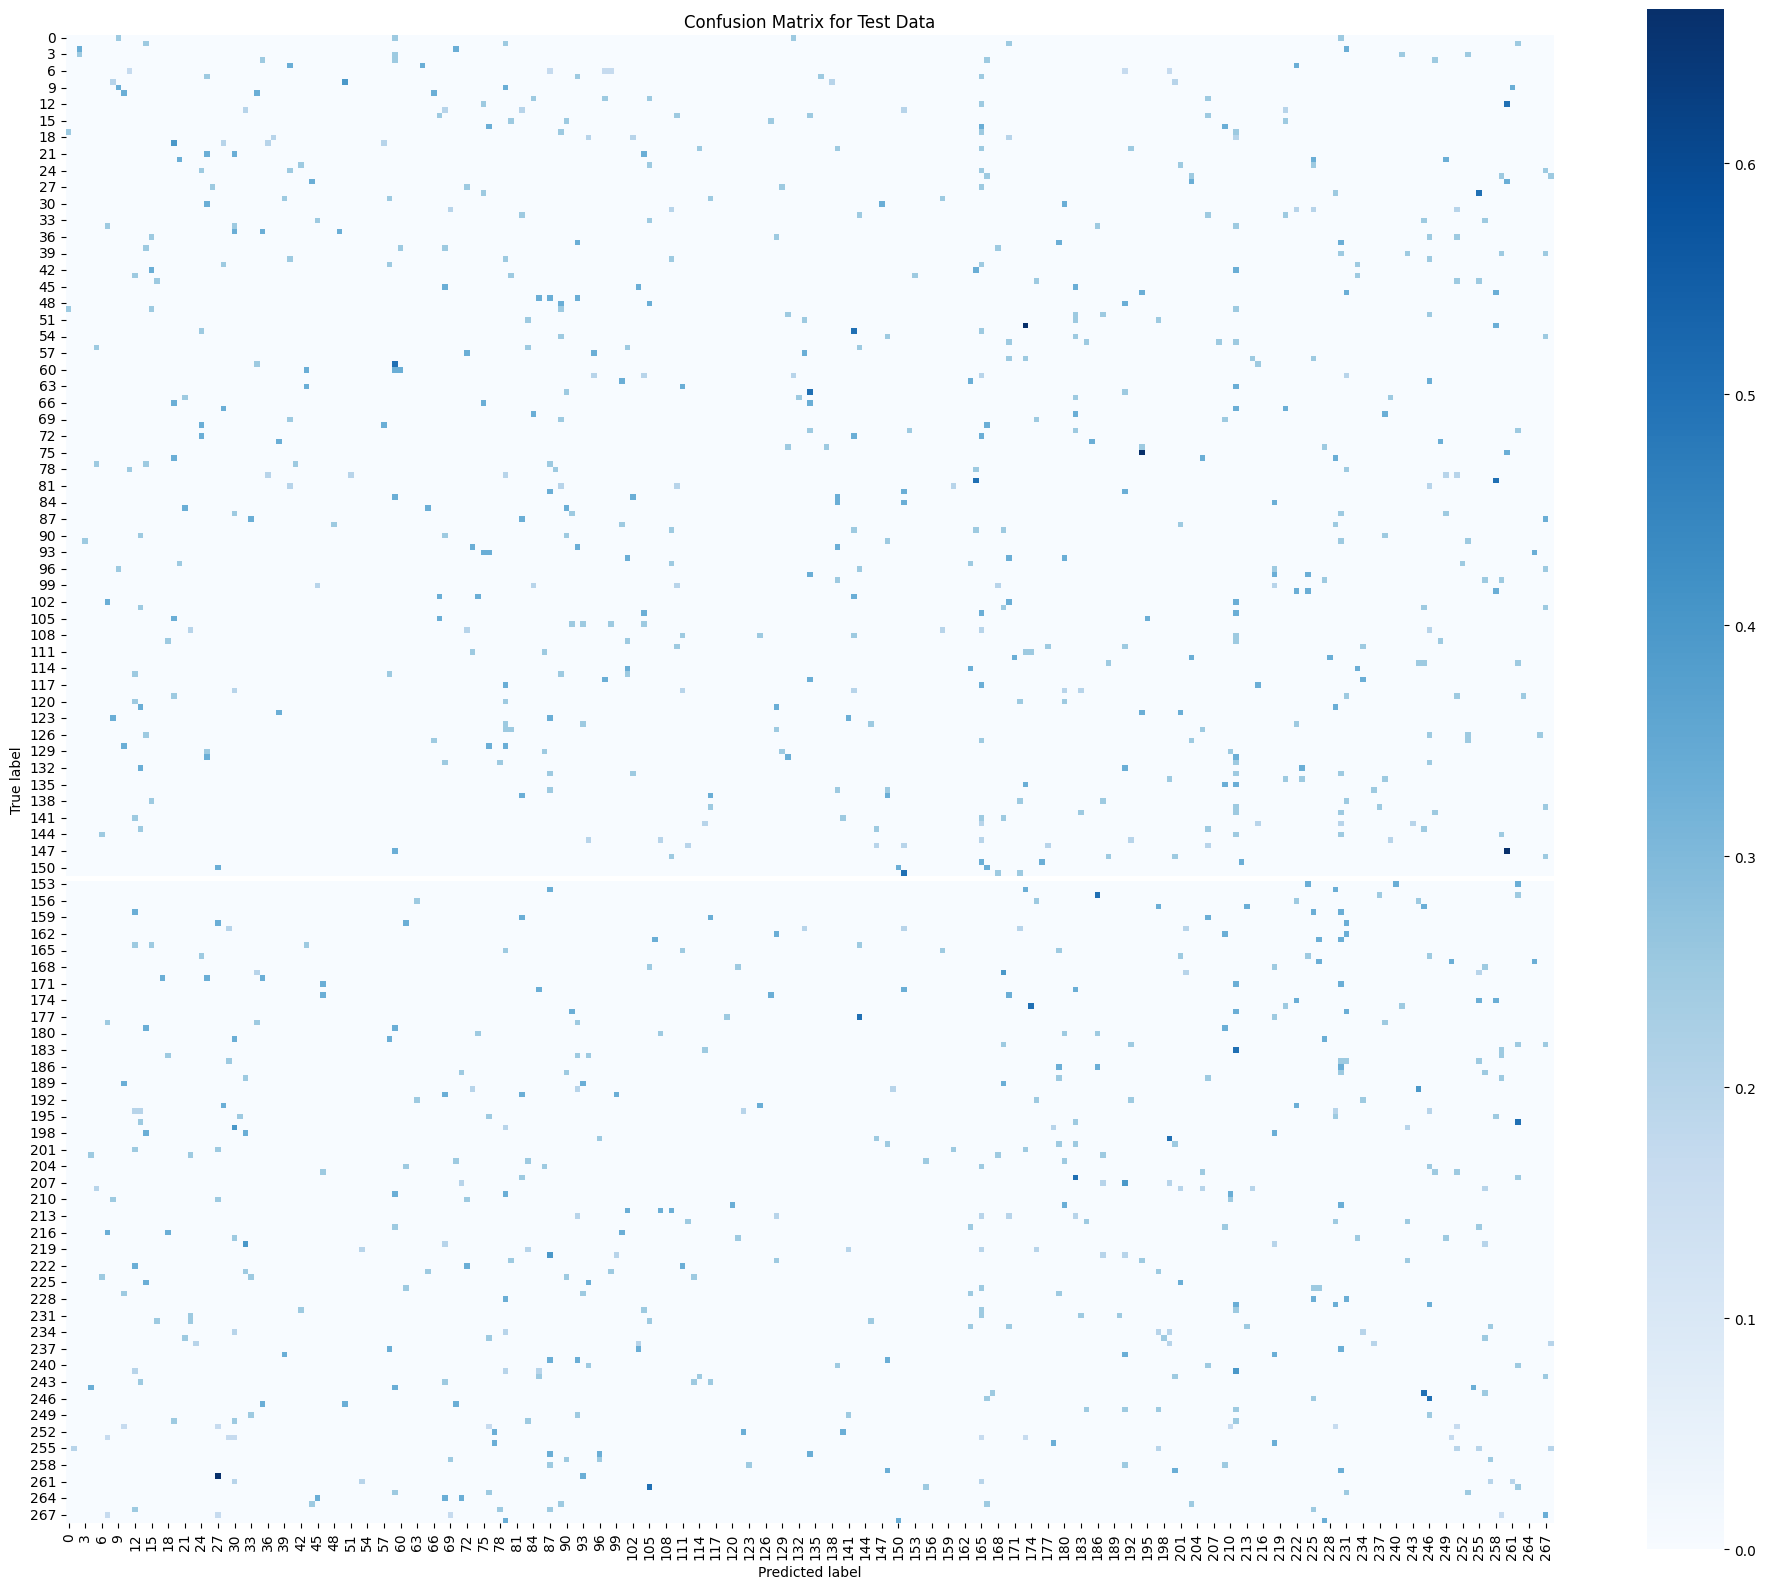

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred_probabilities = model.predict(X_test)
Y_pred = np.argmax(Y_pred_probabilities, axis=1)
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(24, 20))
sns.heatmap(conf_matrix, cmap='Blues', annot=False, square=True)

plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [48]:
del X_test, Y_test
gc.collect()

24594

---